# HIPSC Experiment

In [1]:
# env setup for colab
# %%capture
# !git clone https://github.com/infprobscix/gplvm_scrna.git gplvm
# !cd gplvm
# !pip install gpytorch gdown scanpy
# import os; os.chdir('gplvm')
# !gdown 1qpzL2vdEtb_oo-78iRmHLiMHbZH2jyl_ -O data/ --folder
# !cd notebooks
# import os; os.chdir('notebooks')
# NEED TO RESTART RUNTIME! Then run:
# !cd gplvm/notebooks
# import os; os.chdir('gplvm/notebooks')

# env setup for conda
# conda create -n gplvm python=3.8 numpy scipy matplotlib tqdm pandas ipython
# conda activate gplvm
# pip install torch gpytorch gdown scanpy tensorflow --extra-index-url https://download.pytorch.org/whl/cu113

In [2]:
import sys
sys.path.append('../')

import os, torch
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.sparse as sp
from collections import namedtuple

from model import GPLVM, PointLatentVariable, GaussianLikelihood, train

import matplotlib
import matplotlib.pyplot as plt
plt.ion(); plt.style.use('ggplot')

torch.manual_seed(42)

In [3]:
## Data prep
X_covars = np.array(pd.read_csv('../data/hipsci_ipscs/model_mat.csv'))
X_covars = torch.tensor(X_covars).float()
X_covars[:, 1] -= X_covars[:, 1].mean()
X_covars[:, 1] /= X_covars[:, 1].std()

Y = torch.tensor(sp.load_npz('../data/hipsci_ipscs/data.npz').T.todense())
Y /= Y.std(axis=0)

(n, d), q = Y.shape, 6
period_scale = np.pi

X_latent = torch.tensor(np.load('../data/hipsci_ipscs/init_x.npy')).float()

In [4]:
## Model initialize
X_latent = PointLatentVariable(X_latent)

gplvm = GPLVM(n, d, q,
              covariate_dim=len(X_covars.T),
              n_inducing=len(X_covars.T) + 1,
              period_scale=np.pi,
              X_latent=X_latent,
              X_covars=X_covars
             )
likelihood = GaussianLikelihood(batch_shape=gplvm.batch_shape)

In [5]:
## Model fit
## A state dict is provided with the data and hence it is not necessary to rerun training here
# if torch.cuda.is_available():
#     Y = Y.cuda()
#     gplvm = gplvm.cuda()
#     gplvm.X_covars = gplvm.X_covars.cuda()
#     likelihood = likelihood.cuda()

# gplvm.X_latent.X.requires_grad_(False)
# losses = train(gplvm=gplvm, likelihood=likelihood, Y=Y,
#                epochs=3, batch_size=220, lr=0.05) # 3min

# gplvm.X_latent.X.requires_grad_(True)
# losses = train(gplvm=gplvm, likelihood=likelihood, Y=Y,
#                epochs=47, batch_size=220, lr=0.005) # 27min

In [6]:
## Save/load params

# with open('../data/hipsci_ipscs/model_params_cpu_bs200_50ep.pkl', 'wb') as file:
#     state_dicts = (gplvm.cpu().state_dict(), likelihood.cpu().state_dict())
#     pkl.dump(state_dicts, file)

# if torch.cuda.is_available():
#     Y = Y.cuda()
#     gplvm = gplvm.cuda()
#     gplvm.X_covars = gplvm.X_covars.cuda()
#     likelihood = likelihood.cuda()

with open('../data/hipsci_ipscs/model_params_cpu_bs200_50ep.pkl', 'rb') as file:
    state_dicts = pkl.load(file)
    gplvm.load_state_dict(state_dicts[0])
    likelihood.load_state_dict(state_dicts[1])

In [7]:
## Plot data processing
import scanpy as sc
adata = sc.read_h5ad('../data/hipsci_ipscs/ipsc_scRNA.h5ad')

with open('../data/hipsci_ipscs/model_params_cpu_bs200_50ep.pkl', 'rb') as f:
    gplvm_cpu, lik_cpu = pkl.load(f)

lenscales = gplvm_cpu['covar_module.base_kernel.kernels.0.kernels.1.raw_lengthscale']

adata.obsm['X_BGPLVM_latent_scaled'] = gplvm_cpu['X_latent.X'][:,1:].numpy()/lenscales.numpy()
adata.obsm['X_BGPLVM_latent'] = gplvm_cpu['X_latent.X'][:,1:].numpy()
adata.obsm['X_BGPLVM_latent_scaled'] = gplvm_cpu['X_latent.X'][:,1:].numpy()/lenscales.numpy()
adata.obs['cellcycle_pseudotime'] = gplvm_cpu['X_latent.X'][:,0].numpy()

plt.rcParams['figure.figsize'] = [7,7]

old_lvs = pd.read_table('../data/hipsci_ipscs/lv.txt', header=None) # benchmark from natsuhiko's run

adata.obsm['X_BGPLVM_latent_old'] = old_lvs.values
## Exclude hidden batch effect/plate effect covars
adata.obsm['X_BGPLVM_latent_plt']= adata.obsm['X_BGPLVM_latent_scaled'][:,[1,3,4,5]]

sc.pp.neighbors(adata, use_rep='X_BGPLVM_latent_plt', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.2, spread=1.0)

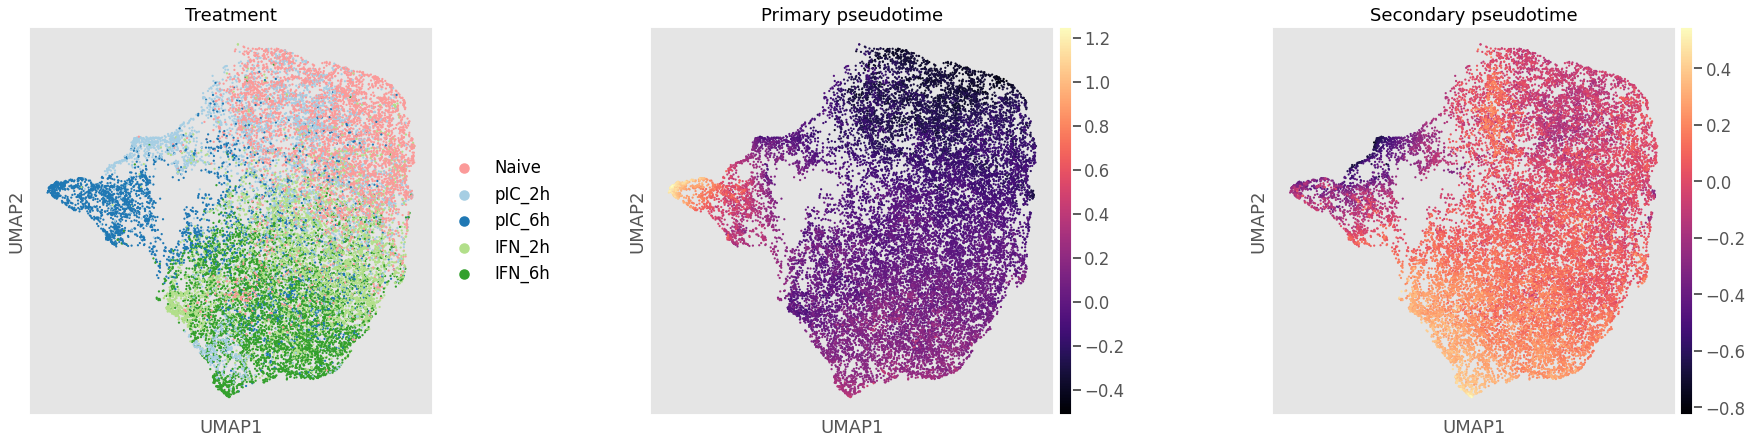

In [8]:
## figure 1 part 1
import seaborn as sns

adata.obs['condition'] = adata.obs['condition'].cat.reorder_categories(['Naive','pIC_2h', 'pIC_6h', 'IFN_2h', 'IFN_6h'])
adata.uns['condition_colors'] = [matplotlib.colors.rgb2hex(sns.color_palette("Paired")[4])] + [matplotlib.colors.rgb2hex(sns.color_palette("Paired")[i]) for i in range(4)]

adata.obs['primary_pseudotime'] = adata.obsm['X_BGPLVM_latent_scaled'][:,1]
adata.obs['secondary_pseudotime'] =  - adata.obsm['X_BGPLVM_latent_scaled'][:,3]

sns.set_context('talk');
sc.pl.umap(adata[~adata.obs['condition'].isna()],color=['condition', 'primary_pseudotime', 'secondary_pseudotime'], 
           title=['Treatment', "Primary pseudotime", 'Secondary pseudotime'],
           size=20, cmap='magma', wspace=0.4, save='ipscs_GPLVM.png');

In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.2, spread=1.0)
adata.obsm['X_umap_pca'] = adata.obsm['X_umap'].copy()
sc.pp.neighbors(adata, use_rep='X_BGPLVM_latent', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.2, spread=1.0)
adata.obsm['X_umap_BGPLVM'] = adata.obsm['X_umap'].copy()

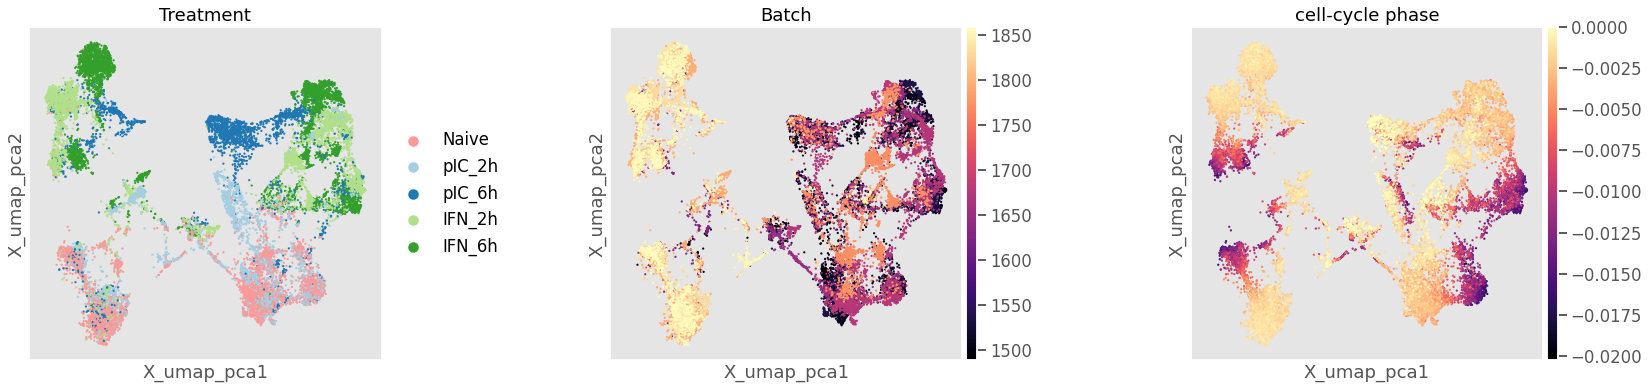

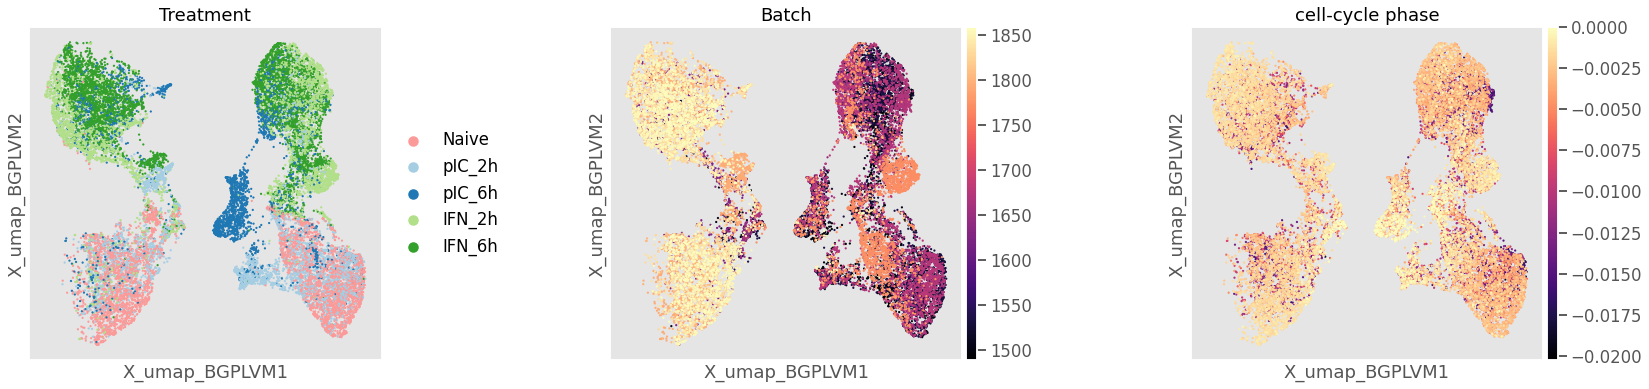

In [10]:
# figure 6
plt.rcParams['figure.figsize'] = [6,6]
sns.set_context('talk');
sc.pl.embedding(adata[~adata.obs['condition'].isna()], "X_umap_pca", color=['condition', 'plate', 'g2m.phase'], 
           title=['Treatment', 'Batch', 'cell-cycle phase'],size=20, cmap='magma', wspace=0.5, save='ipscs_PCA_all.png');
sns.set_context('talk');
sc.pl.embedding(adata[~adata.obs['condition'].isna()], 'X_umap_BGPLVM',color=['condition', 'plate', 'g2m.phase'], 
           title=['Treatment', 'Batch', 'cell-cycle phase'],size=20, cmap='magma', wspace=0.5, save='ipscs_GPLVM_all.png');

In [11]:
t = adata.obs['cellcycle_pseudotime'] % np.pi

Y = adata.X.copy().toarray()
meta=pd.read_csv('../data/hipsci_ipscs/meta_data.csv')

genes = namedtuple('genes', ['CDC6', 'UBE2C', 'FN1'])
genes = genes(CDC6=4154, UBE2C=4493, FN1=845)

X_plot = torch.zeros(100, q + 1 + len(gplvm.X_covars.T)).to(gplvm.X_covars.device) +\
             torch.cat([gplvm.X_latent(), gplvm.X_covars], axis=1).mean(axis=0)
X_plot[:, 0] = torch.linspace(0, np.pi, len(X_plot))
preds = gplvm(X_plot).loc.T.detach().cpu()
X_plot = X_plot.cpu()

/home/aditya/miniconda3/envs/gplvm/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
/home/aditya/miniconda3/envs/gplvm/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


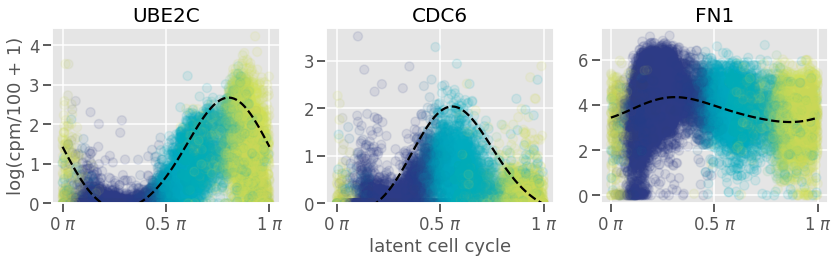

In [12]:
# figure 1 part 2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))
ax1.scatter(t/np.pi, Y[:, genes.UBE2C], alpha=0.1, c=meta.cc_col)
ax1.plot(X_plot[:, 0].detach().numpy()/np.pi, preds[:, genes.UBE2C].detach().numpy(), c='black', linestyle='dashed')
ax1.set_ylim(0)
ax1.set_title('UBE2C', fontsize=20)
ax2.scatter(t/np.pi, Y[:, genes.CDC6], alpha=0.1, c=meta.cc_col)
ax2.plot(X_plot[:, 0].detach().numpy()/np.pi, preds[:, genes.CDC6].detach().numpy(), c='black', linestyle='dashed')
ax2.set_title('CDC6', fontsize=20)
ax2.set_ylim(0)
ax3.scatter(t/np.pi, Y[:, genes.FN1], alpha=0.1, c=meta.cc_col)
ax3.plot(X_plot[:, 0].detach().numpy()/np.pi, preds[:, genes.FN1].detach().numpy(), c='black', linestyle='dashed')
ax3.set_title('FN1', fontsize=20)
ax2.set_xlabel('latent cell cycle', fontsize=18)
ax1.set_ylabel('log(cpm/100 + 1)', fontsize=18)
plt.tight_layout()
ax1.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
ax2.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
ax3.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
fig.savefig('cellcycle_genes.png')